### Test with Embeddings

This code uses precalculated embeddings (see other notebooks for calculation) to greatly speed segmentation computation. We investigate hyperparameter tuning on vanilla AMI meeting transcripts, randomly concatenated AMI meeting transcripts with artificial labels, and randomly concatenated AMI meeting transcripts with true labels. This allows us to assess the suitability of  concatenation segmentation tuning as a proxy task for vanilla tuning.

See `demonstrate_segmentation_methods.ipynb` for a more in-depth description of our segmentation and evaluation tools.

In [1]:
from unsupervised_topic_segmentation import core, eval, types, dataset
import create_test_data
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
import create_test_data

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
with open('data/transcripts_with_embeds.pickle', 'rb') as handle:
    test_data = pickle.load(handle)

In [6]:
test_data = dataset.add_durations(test_data)  # "duration" column is just number of words
test_data = dataset.preprocessing(test_data,min_caption_len=20)  # note that this adds (old) `index` column, but topic_segmentation uses actual index

In [11]:
new_algorithm = types.BERTSegmentation(
    sentence_comparison_window=50,
    text_tiling=types.NewSegmentation(
        stdevs=1))

new_algorithm

BERTSegmentation(SENTENCE_COMPARISON_WINDOW=50, TEXT_TILING=NewSegmentation(STDEVS=1))

First, let's just demonstrate the performance speedup from using precalculated embeddings

In [12]:
example_data = test_data[test_data.meeting_id=='AMI_0']

# runs in 14s on Drew's machine
core.topic_segmentation(
    topic_segmentation_algorithm=new_algorithm,
    df=example_data,
    embedding_col_name="not-used!")

No embedding column found, running RoBERTa inference.


{'AMI_0': [54, 70, 80, 139, 145]}

In [13]:
# runs in less than 0.1s on Drew's machine
core.topic_segmentation(
    topic_segmentation_algorithm=new_algorithm,
    df=example_data,
    embedding_col_name="embedding")

{'AMI_0': [50, 64, 135]}

_Vanilla AMI Hyperparameter Tuning_

In [ ]:
comparison_windows=[40,50,70,90]
stds=[1,2,2.5,3,3.5]
model_hyperparams=[]
pks = []
windiffs =[]
segmentations = []

new_algorithm = types.BERTSegmentation(
    sentence_comparison_window=50,
    text_tiling=types.NewSegmentation(
        stdevs=1))

for window in comparison_windows:
    for std in stds:
        algorithm = types.BERTSegmentation(
            sentence_comparison_window=window,text_tiling=types.NewSegmentation(stdevs=std))
        model_hyperparams.append((window,std))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results, segmentation = eval.eval_topic_segmentation(
                topic_segmentation_algorithm=algorithm,input_df=test_data,return_segmentation=True)
        pks.append(results['average_Pk_'])
        windiffs.append(results['average_windiff_'])
        segmentations.append(segmentation)

In [22]:
segmentation_means = [np.mean([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]
segmentation_stds = [np.std([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]

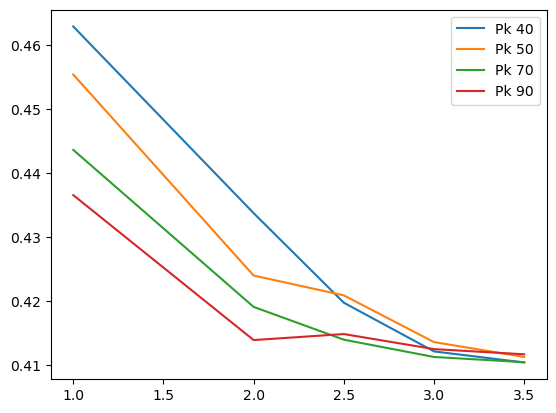

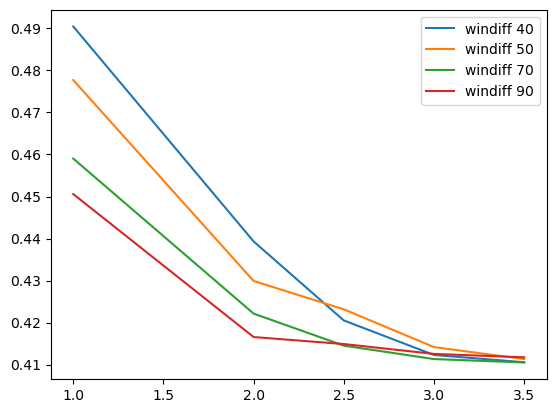

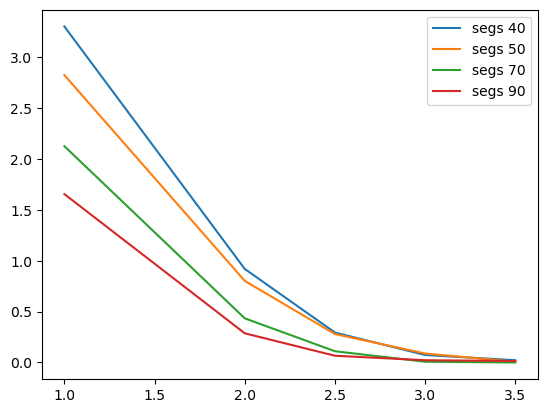

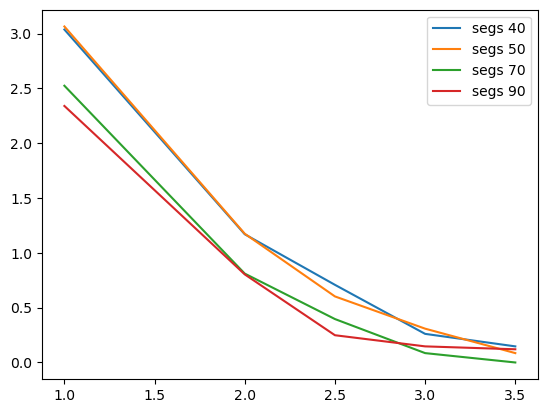

In [25]:
legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    legend.append(f'Pk {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    legend.append(f'windiff {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_means[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_stds[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

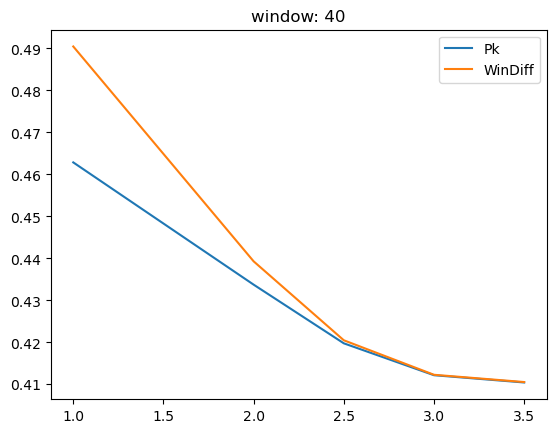

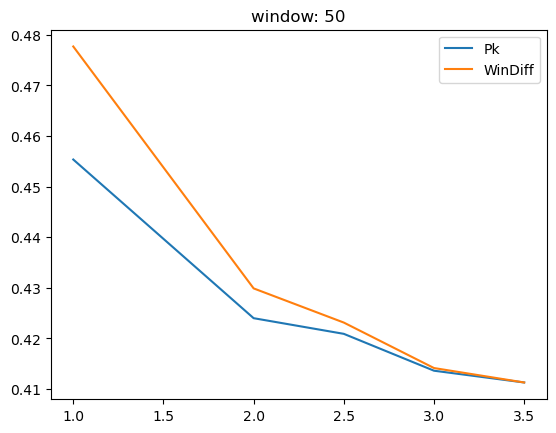

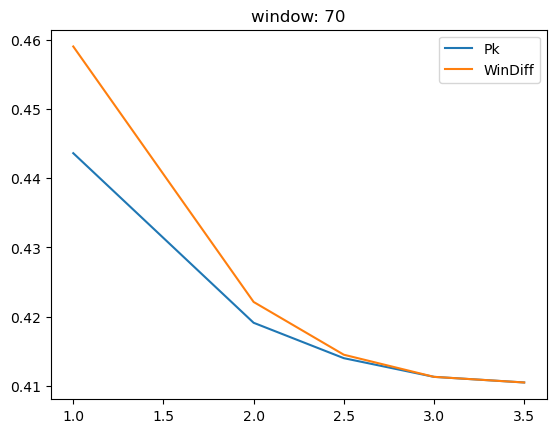

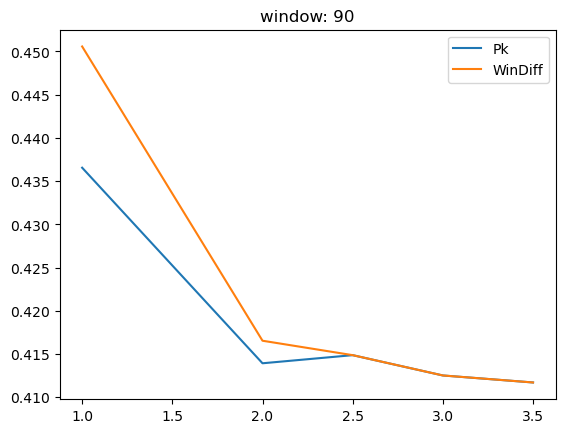

In [13]:
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    plt.title(f'window: {model_hyperparams[i*len(stds)][0]}')
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    plt.title(f'window: {model_hyperparams[i*len(stds)][0]}')
    plt.legend(['Pk','WinDiff'])
    plt.show()

In [26]:
comparison_windows=[10,20,30]
stds=[1,2,2.5,3,3.5]

for window in comparison_windows:
    for std in stds:
        algorithm = types.BERTSegmentation(
            sentence_comparison_window=window,text_tiling=types.NewSegmentation(stdevs=std))
        model_hyperparams.append((window,std))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results, segmentation = eval.eval_topic_segmentation(
                topic_segmentation_algorithm=algorithm,input_df=test_data,return_segmentation=True)
        pks.append(results['average_Pk_'])
        windiffs.append(results['average_windiff_'])
        segmentations.append(segmentation)

In [27]:
comparison_windows = [40,50,70,90] + comparison_windows

In [29]:
segmentation_means += [np.mean([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]
segmentation_stds += [np.std([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]

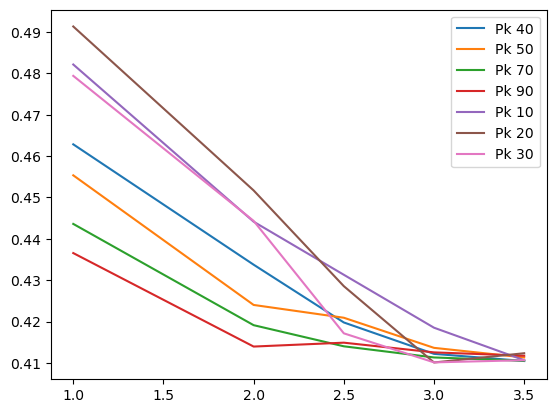

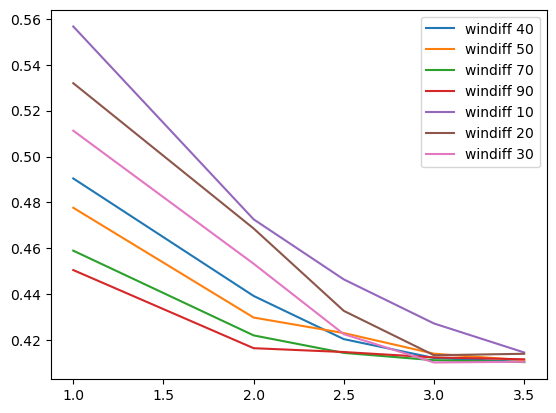

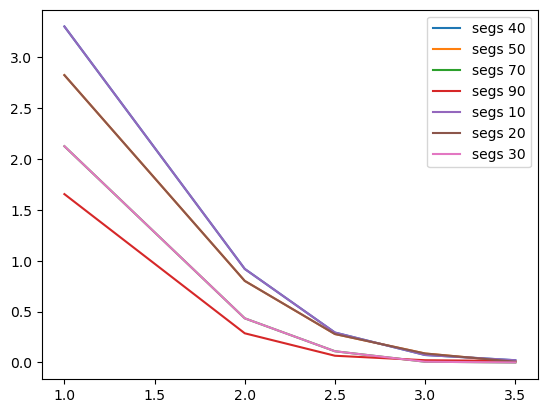

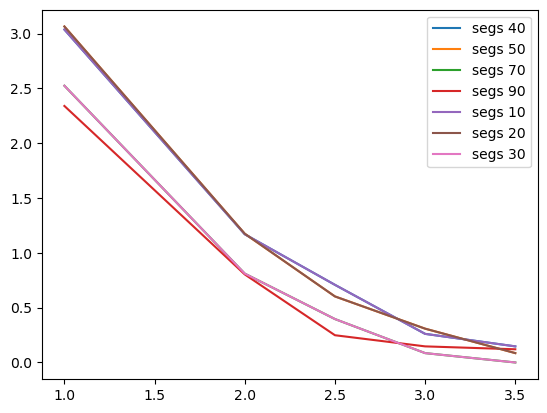

In [30]:
legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    legend.append(f'Pk {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    legend.append(f'windiff {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_means[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_stds[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

In [32]:
comparison_windows=[10,30,50,70]
stds=[0.5,1,2,3]
model_hyperparams=[]
pks = []
windiffs =[]
segmentations = []

for window in comparison_windows:
    for std in stds:
        algorithm = types.BERTSegmentation(
            sentence_comparison_window=window,text_tiling=types.NewSegmentation(stdevs=std))
        model_hyperparams.append((window,std))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results, segmentation = eval.eval_topic_segmentation(
                topic_segmentation_algorithm=algorithm,input_df=test_data,return_segmentation=True)
        pks.append(results['average_Pk_'])
        windiffs.append(results['average_windiff_'])
        segmentations.append(segmentation)

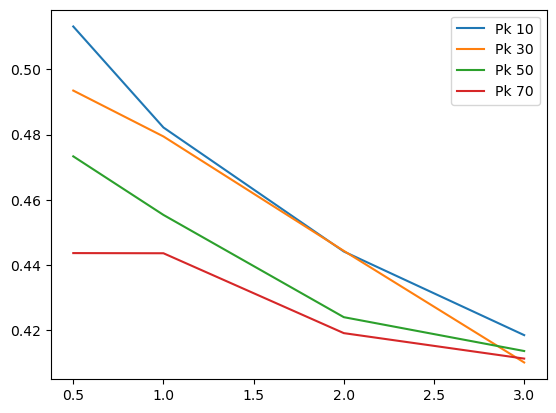

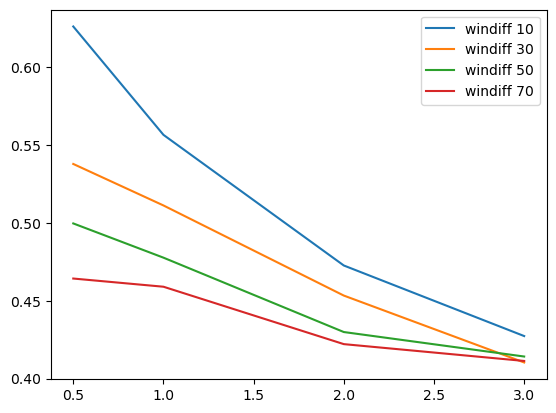

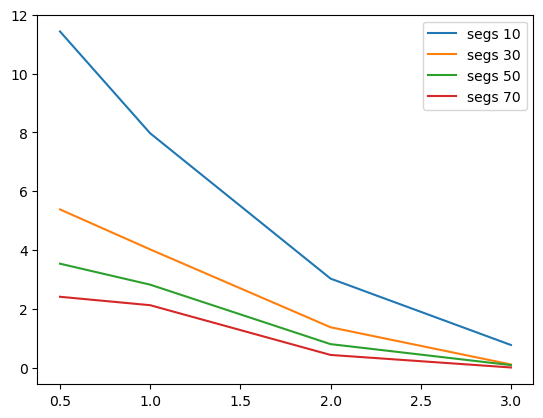

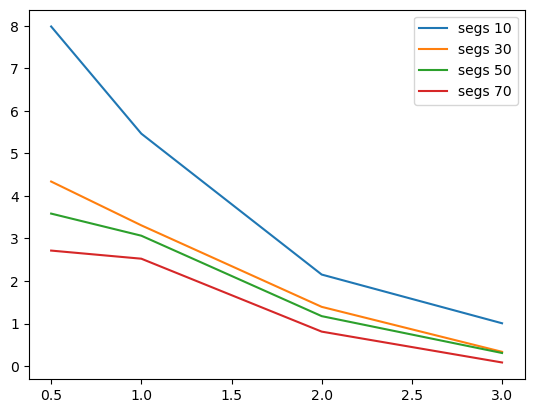

In [33]:
segmentation_means = [np.mean([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]
segmentation_stds = [np.std([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    legend.append(f'Pk {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    legend.append(f'windiff {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_means[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_stds[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

# Artificial Segmentation

In [15]:
def data_gen(transcript_id=None,doc_count_min:int=2,doc_count_max:int=10,sentence_min:int=20):
    results, embedding, labels, topics, doc_count = create_test_data.generate_segment(
        t=test_data.rename(columns={'caption':'sentences','label':'topic_counts'}).groupby(['meeting_id'], as_index = False).agg({
        'sentences':lambda x: list(x),
        'embedding':lambda x: list(x),
        'topic_counts':lambda x: list(x)}),
        embeddings=True, labeled=True,
        doc_count_min=doc_count_min,
        doc_count_max=doc_count_max,
        sentence_min = sentence_min)
    if len(labels)==len(results):
        return dataset.add_durations(pd.DataFrame({
                            'meeting_id':[transcript_id]*len(results),
                            'caption':results,
                            'embedding':embedding,
                            'label':labels,
                            'true_label':topics,
                            'doc_count':[doc_count]*len(results)
                            })
                            ,'caption') 
    else:
        return None


def dataset_gen(n_transcripts:int,doc_count_min:int=2,doc_count_max:int=10,sentence_min:int=20):
    df=None
    for i in range(n_transcripts):
        temp=data_gen("rand_"+str(i),doc_count_min,doc_count_max,sentence_min)
        if df is None:
            df=temp
        elif temp is not None:
            df=pd.concat([df,temp])
    return df


In [25]:
doc_count_min = 2
doc_count_max = 10
sentence_min = 20

artificial_data=dataset_gen(500,doc_count_min,doc_count_max,sentence_min)
artificial_data.columns

Index(['meeting_id', 'caption', 'embedding', 'label', 'true_label',
       'doc_count', 'end_time', 'start_time'],
      dtype='object')

In [16]:
doc_count_min = 2
doc_count_max = 5
sentence_min = 20

artificial_data_small=dataset_gen(10,doc_count_min=doc_count_min,doc_count_max=doc_count_max,sentence_min=sentence_min)
artificial_data_small.columns

Index(['meeting_id', 'caption', 'embedding', 'label', 'true_label',
       'doc_count', 'end_time', 'start_time'],
      dtype='object')

In [17]:
artificial_data_small

,meeting_id,caption,embedding,label,true_label,doc_count,end_time,start_time
0,rand_0,W what ? Alri alright . We'll see .,"[[tensor(0.0364, dtype=torch.float64), tensor(...",0,0,5,10,0
1,rand_0,Some extra deciding .,"[[tensor(0.0483, dtype=torch.float64), tensor(...",0,0,5,14,10
2,rand_0,I'll show you the notes again .,"[[tensor(0.0381, dtype=torch.float64), tensor(...",0,0,5,22,14
3,rand_0,Well you'll you two will present us your prot...,"[[tensor(0.1444, dtype=torch.float64), tensor(...",0,0,5,33,22
4,rand_0,Then I guess that's your bit ?,"[[tensor(0.1365, dtype=torch.float64), tensor(...",0,0,5,42,33
...,...,...,...,...,...,...,...,...
276,rand_9,the the personal coach will give you the your ...,"[[tensor(0.0426, dtype=torch.float64), tensor(...",3,3003,4,3530,3514
277,rand_9,So we'll just meet back in here thirty minutes .,"[[tensor(-0.0267, dtype=torch.float64), tensor...",3,3003,4,3540,3530
278,rand_9,I'm sure we have that .,"[[tensor(0.0488, dtype=torch.float64), tensor(...",3,3003,4,3546,3540
279,rand_9,thanks for attending .,"[[tensor(-0.0880, dtype=torch.float64), tensor...",3,3003,4,3550,3546


In [26]:
#took 28 minutes to run
comparison_windows=[10,30,50,70]
stds=[0.5,1,2,3]

model_hyperparams=[]
pks = []
windiffs =[]
segmentations = []

for window in comparison_windows:
    for std in stds:
        algorithm = types.BERTSegmentation(
            sentence_comparison_window=window,text_tiling=types.NewSegmentation(stdevs=std))
        model_hyperparams.append((window,std))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results, segmentation = eval.eval_topic_segmentation(
                topic_segmentation_algorithm=algorithm,input_df=artificial_data,return_segmentation=True)
        pks.append(results['average_Pk_'])
        windiffs.append(results['average_windiff_'])
        segmentations.append(segmentation)

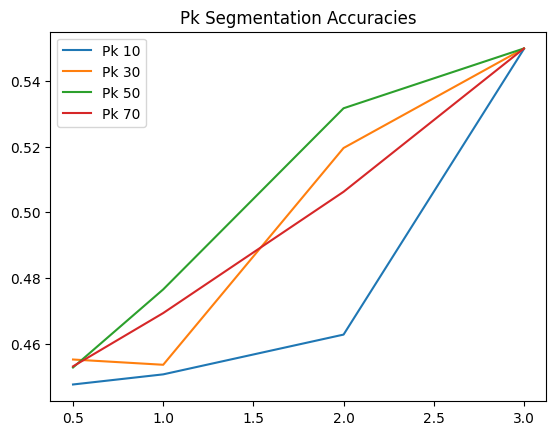

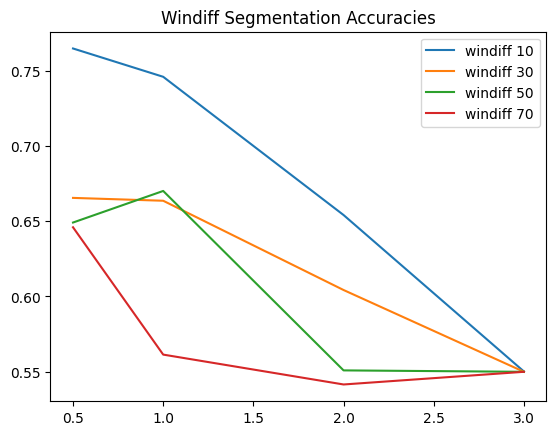

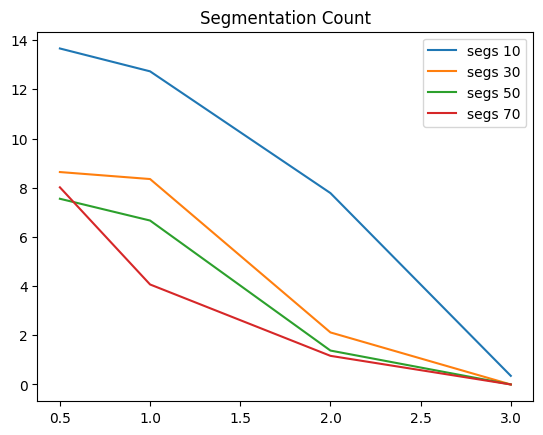

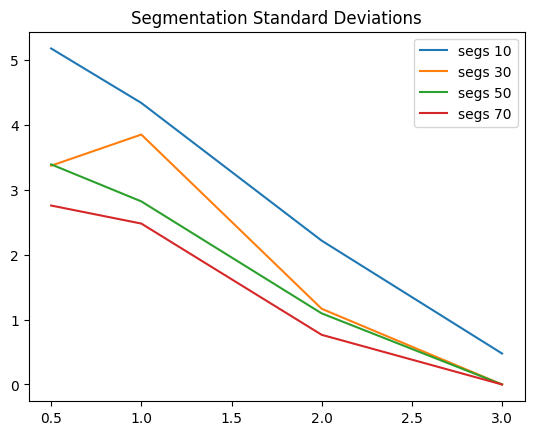

In [27]:
segmentation_means = [np.mean([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]
segmentation_stds = [np.std([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    legend.append(f'Pk {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Pk Segmentation Accuracies")
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    legend.append(f'windiff {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Windiff Segmentation Accuracies")
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_means[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Segmentation Count")
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_stds[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Segmentation Standard Deviations")
plt.show()


In [172]:
import statistics
statistics.median([len(x) for x in segmentations[0].values()])

len(segmentations)

16

# Test on the results

In [29]:
#took 28 minutes to run
comparison_windows=[10,30,50,70]
stds=[0.5,1,2,3]

model_hyperparams=[]
pks = []
windiffs =[]
segmentations = []

for window in comparison_windows:
    for std in stds:
        algorithm = types.BERTSegmentation(
            sentence_comparison_window=window,text_tiling=types.NewSegmentation(stdevs=std))
        model_hyperparams.append((window,std))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results, segmentation = eval.eval_topic_segmentation(
                topic_segmentation_algorithm=algorithm,input_df=artificial_data,
                return_segmentation=True, 
                col_names=('meeting_id', 'start', 'end' , 'caption', 'true_label'))
        pks.append(results['average_Pk_'])
        windiffs.append(results['average_windiff_'])
        segmentations.append(segmentation)

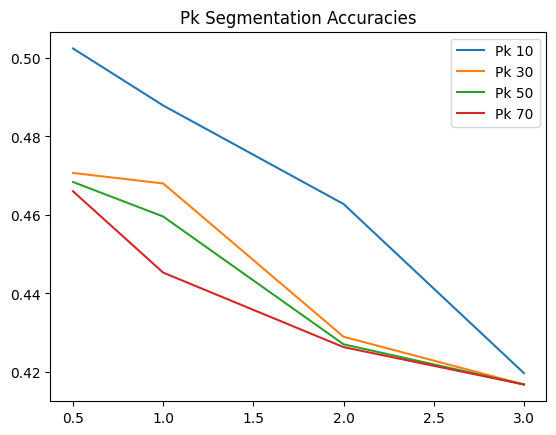

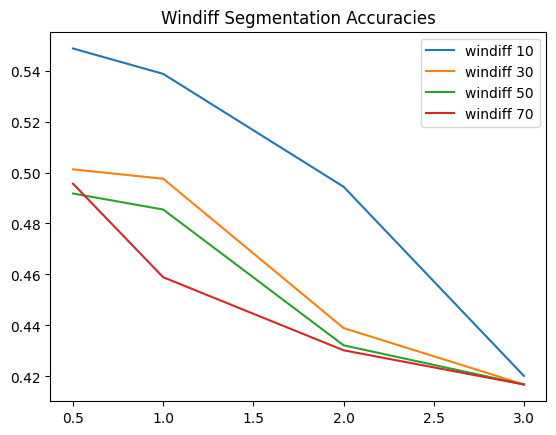

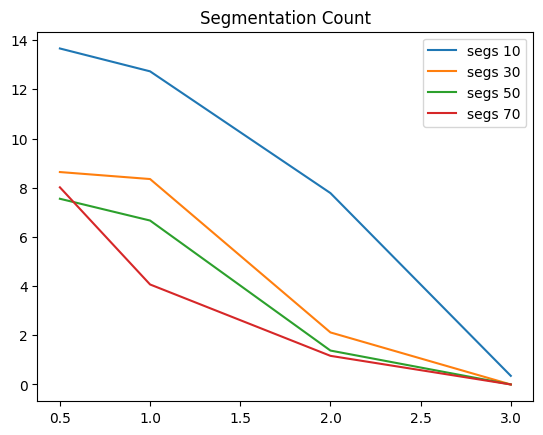

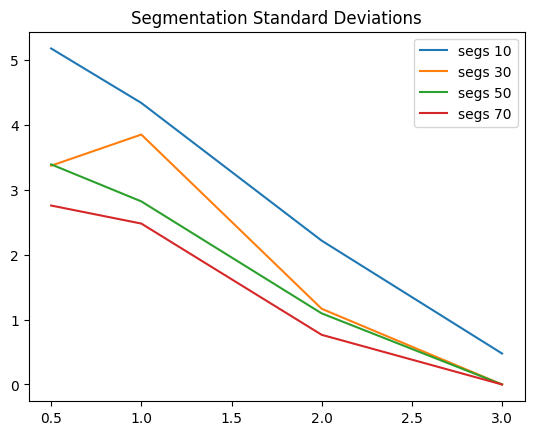

In [30]:
segmentation_means = [np.mean([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]
segmentation_stds = [np.std([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    legend.append(f'Pk {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Pk Segmentation Accuracies")
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    legend.append(f'windiff {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Windiff Segmentation Accuracies")
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_means[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Segmentation Count")
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_stds[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Segmentation Standard Deviations")
plt.show()


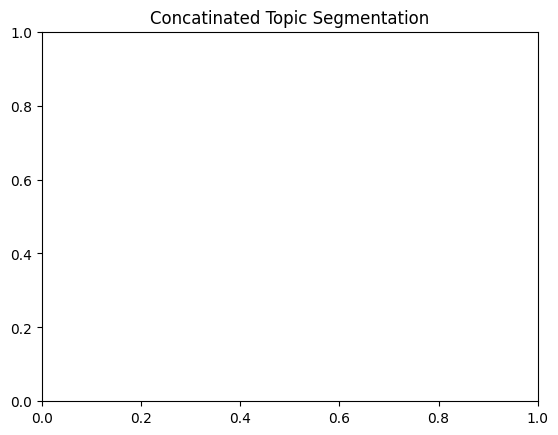

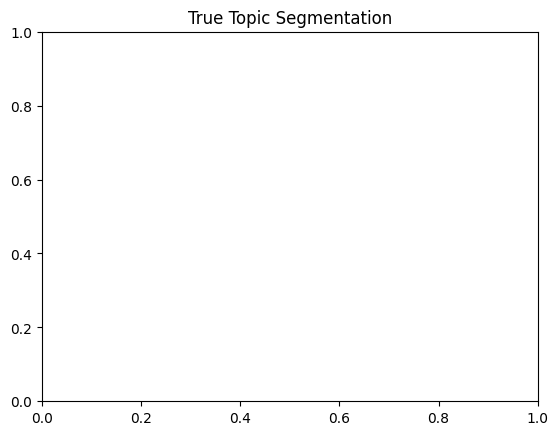

In [34]:

legend = []
plt.title("Concatinated Topic Segmentation")
plt.show()

legend = []
plt.title("True Topic Segmentation")
plt.show()